<a href="https://colab.research.google.com/github/vivekshaoutlook/machine_learning/blob/master/06_Ensemble_and_Stacking_on_Titanic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import KFold
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

In [308]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic_train.csv")

In [0]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic_test.csv")

In [311]:
train.shape

(891, 12)

In [312]:
test.shape

(418, 11)

In [0]:
full_data = [train,test]

**SECTION1: CLEANING AND FEATURE ENGINEERING**

In [0]:
#feature engineering
#F1. new feature - name_length
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)


In [0]:
#F2.new feature - "Has_Cabin".whether the passenger had a cabin
train["Has_cabin"] = train["Cabin"].isnull().astype(int)
test["Has_cabin"] = test["Cabin"].isnull().astype(int)

In [0]:
#F3.new feature: Family_size 
#instead of seprately adding new columns, like we did above, we can also use the full_data array
#the plus 1 in the end includes the passenger himeself/herself :)
for dataset in full_data:
  dataset["Family_size"] = dataset['SibSp'] + dataset['Parch'] + 1


In [0]:
#F4.new feature-IsAlone. a Was the person traveling alone
for dataset in full_data:
  dataset["IsAlone"]=0 # create a new column "IsAlone" and initialize it to 0
  dataset.loc[dataset["Family_size"]==1,"IsAlone"]=1 #set the "IsAlone" column to 1 where the Family_Size=1


In [318]:
print(train["Embarked"].value_counts())
print(test["Embarked"].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    270
C    102
Q     46
Name: Embarked, dtype: int64


In [0]:
#C1.Cleaning.Since majority of people have embarked from port S, we can default S for missing values
for dataset in full_data:
  dataset["Embarked"] = dataset["Embarked"].fillna("S")
 

In [320]:
#verify that now no missing values in Embarked column
print(train["Embarked"].isna().sum())
print(test["Embarked"].isna().sum())

0
0


In [0]:
#C2.Filling missing fare with the median 
for dataset in full_data:
  dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())
  

In [0]:
#F5.creating a new  categorical feature - CategoricalFare
train["CategoricalFare"] = pd.qcut(train['Fare'], 4)

In [323]:
#let's see what range(bucket) got created and how many values in each range
train["CategoricalFare"].value_counts()

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: CategoricalFare, dtype: int64

In [0]:
#C3.filling missign Age
for dataset in full_data:
 avg_age = np.mean(dataset["Age"])
 std_dev_of_age = np.std(dataset["Age"])
 missing_age_count = np.isnan(dataset["Age"]).sum()
 missing_age_random_list = np.random.randint(avg_age-std_dev_of_age,avg_age+std_dev_of_age,missing_age_count)
 dataset['Age'][np.isnan(dataset['Age'])] = missing_age_random_list
 dataset['Age'] = dataset['Age'].astype(int)




In [0]:
#F6.Creating a new categorical feature - CategoricalAge
train["CategoricalAge"] = pd.cut(train["Age"],5)


In [326]:
#let's see what range(bucket) got created and how many values in each range
train["CategoricalAge"].value_counts()

(16.0, 32.0]     454
(32.0, 48.0]     251
(-0.08, 16.0]    106
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: CategoricalAge, dtype: int64

In [0]:
#F7: create a new feature-Title
def get_title(name):
  title_text = re.search('([A-Za-z]+)\.',name)
  if title_text:
    return  title_text.group()
  else:
    return ""
  
for dataset in full_data:
  dataset["Title"] = dataset["Name"].apply(get_title)

In [328]:
train["Title"].value_counts()


Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Col.           2
Major.         2
Mme.           1
Lady.          1
Ms.            1
Capt.          1
Countess.      1
Jonkheer.      1
Don.           1
Sir.           1
Name: Title, dtype: int64

In [0]:
 #C4: replace less common titles with a single title "Rare"
 rare_title = ['Lady.', 'Countess.','Capt.', 'Col.','Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.']
 for dataset in full_data:
   dataset["Title"] = dataset["Title"].replace(rare_title,"Rare.")
   dataset['Title'] = dataset['Title'].replace('Mlle.', 'Miss.')
   dataset['Title'] = dataset['Title'].replace('Ms.', 'Miss.')
   dataset['Title'] = dataset['Title'].replace('Mme.', 'Mrs.')


In [330]:
#let's verify that the titles have been reduced as desired
train["Title"].value_counts()

Mr.        517
Miss.      185
Mrs.       126
Master.     40
Rare.       23
Name: Title, dtype: int64

In [331]:
test["Title"].value_counts()

Mr.        240
Miss.       79
Mrs.        72
Master.     21
Rare.        6
Name: Title, dtype: int64

In [0]:
#C5: the grand cleaning by converting all categorical to numerical
for dataset in full_data:
  sex_mapping_dict = {'female': 0, 'male': 1}
  titles_mapping_dict = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
  embarked_port_dict = {'S': 0, 'C': 1, 'Q': 2}
    
  dataset["Sex"] = dataset["Sex"].map(sex_mapping_dict).astype(int)
  dataset["Title"] = dataset["Title"].map(titles_mapping_dict)
  dataset["Title"] = dataset["Title"].fillna(0)#still if few titles are not filled, replace those with 0
  dataset["Title"] = dataset["Title"].astype(int)
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  #fare cleaning
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

  #age cleaning
  dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] = 4





In [333]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_cabin,Family_size,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,1,2,0,"(-0.001, 7.91]","(16.0, 32.0]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,0,2,0,"(31.0, 512.329]","(32.0, 48.0]",0
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,22,1,1,1,"(7.91, 14.454]","(16.0, 32.0]",0


In [0]:
#F8: remove unwanted features
#PassengerId: nothing useful here
#Name: we already extracted title and name length.
#Ticket: nothing useful here
#Cabin:already created a new feature - "has_cabin"
#SibSp: already created a new feature - "Family_size". "Parch" still be useful becasue Family_Size - Parch = SibSp
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_columns,axis=1)
test = test.drop(drop_columns,axis=1)
#since CategoricalAge and CategoricalFare related information is now captured in Fare and Age column, can drop these too
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1) #was added only in train set



SECTION2: DATA VISUALIZATION

In [335]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_cabin,Family_size,IsAlone,Title
0,0,3,1,1,0,0,0,23,1,2,0,0
1,1,1,0,2,0,3,1,51,0,2,0,0
2,1,3,0,1,0,1,0,22,1,1,1,0


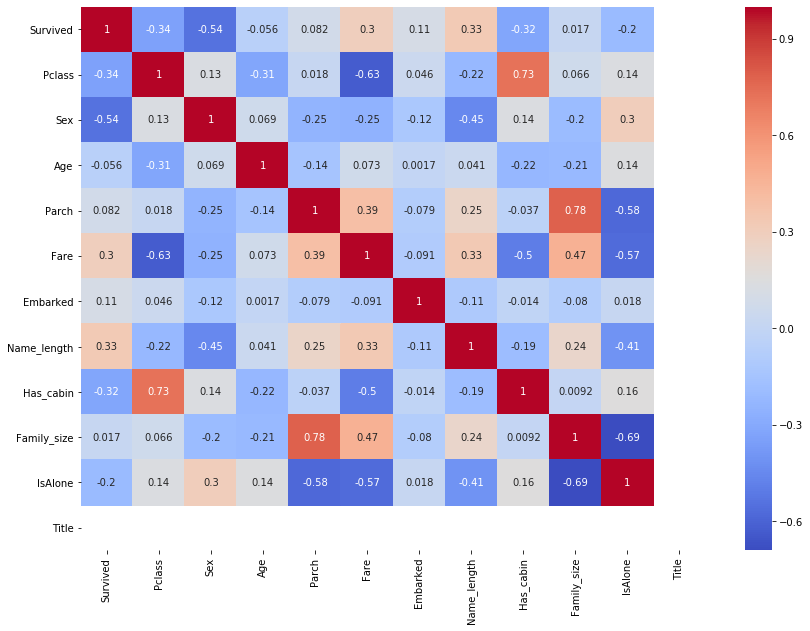

In [336]:
#V1. let's plot heat map to see the correlation among different features
plt.figure(figsize=(14,10))
tc = train.corr()
sns.heatmap(tc,annot=True,cmap = "coolwarm")

In [0]:
#takeaway from heatmap = most of the features are uncorrelated (parch-family_size & Has_cabin-pclass has some correlation though.
#This can be refined further). Uncorrelation among features is good becasue we are not going to pass any redundant feature
#in the model i.e. each feature is gong to provide unique information

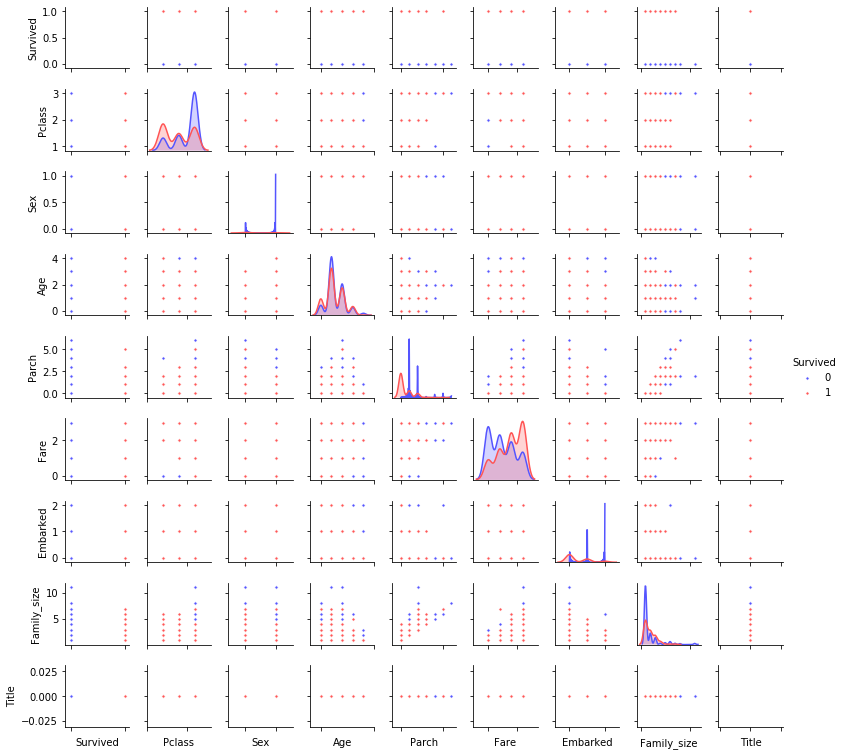

In [338]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'Family_size', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

**SECTION3: ENSEMBLING AND STACKING**

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED,shuffle=False)#though shuffle is 'False" by default itself

In [0]:
# Class to extend the Sklearn classifier
class SKLearnHelper(object):
  #the first argument in constructor (normally called 'self') is used to access instance varaibles.
  #Other subsequent arguments are instance varaibles
  def __init__(self,clf,seed=0,params=None):  
    params['random_state'] = seed#add 'random_state' to the dictionary - 'params'
    self.clf = clf(**params)#pass the arguments to the classifier-clf-by unpacking (**) the dictionary - 'params'
  
  def train(self, x_train, y_train):#note that first argument is 'self' just like the constructor.x_train, y_train are instance varaibles
        self.clf.fit(x_train, y_train) #instance variables are always accessed by 'self'(name of the varaible which was first argument of the constrcutor )
  def predict(self, x):
        return self.clf.predict(x)
  def fit(self,x,y):
        return self.clf.fit(x,y)
  def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [0]:
# TODO:can have a similar Class to extend XGboost classifer

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    i=0
    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i+=i

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [0]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
rf = SKLearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

In [0]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [0]:
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest